# Final Team Project | Deliverable 2: JSON and Streaming Data
BAX 423 | Yiyi Han, Jasmin Zou, Scott Virshup, Sarah Gustafson, and Dane Hamlett

## Part I

### Identify a Data Streaming Service that Outputs JSON

For this component of the final project, we will be using the Twitter Streaming API service to extract a series of real-time tweets, that will be pushed to an online SQL Server database for analysis. The first step in connecting to the API service, is to become familiar with the API and create an application. This will allow us to extract a consumer key and secret, as well as an access token and secret.

<img width="100%" src="https://raw.githubusercontent.com/danehamlett/UC_Davis/master/BAX_423/twitter_api.png"><img>

## Part II

### Understand the Data Model and JSON Representation Used in the Data Stream

By leveraging a common online <a href="https://jsoneditoronline.org/" target="_blank">JSON explorer</a>, we are able to identify the structure of the JSON response. This allows our team to assess the elements that we would like to capture from the API. Below is an image of the JSON response received from an API call.

<img width="100%" src="https://raw.githubusercontent.com/danehamlett/UC_Davis/master/BAX_423/twitter_json.png"><img>

## Parts III & IV

### Leverage Python to Connect to the Streaming API and Push the Results to a Relational Database

In [1]:
## Import Libraries
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
import urllib.request
import json
import pymssql
import pandas as pd
import matplotlib.pyplot as plt

## Establish Connection to Local MS SQL Server Instance, Open Cursor, and Truncate Table Prior to Load
conn = pymssql.connect(host='107.3.137.131:2015', user='svc_hopper', password='User#1', database='UCDavisDB')
cursor = conn.cursor()
cursor.execute('TRUNCATE TABLE [UCDavisDB].[dbo].[Twitter_Data]')

## Twitter API Consumer Key, Consumer Secret, Access Token, and Access Secret
ckey="jQt09QIaJ2iY47fFpTRMbxuVu"
csecret="ACHkeqfYnxxq9rtPYpNKkqrc1cVrsqjoXjHJONlmHet5hhPbAv"
atoken="3191712372-vMKvjBi0KZHhh4CfWDU1j8QA0T5vfZkaeooDPUY"
asecret="irZY4aAWtssjYoisbaiGzWFEoMR98DtpzsfAaVWpPLgnG"

## Create a Class and Function that Will Call the API and Push Results to MS SQL Server
class listener(StreamListener):
    
    ## Print the Tweet Sampling Header
    print("Tweet Sampling:" + "\n")
    
    ## Function to Call the Twitter Streaming API Service
    def on_data(self, data):
        
        ## Full JSON Object (Un-parsed)
        all_data = json.loads(data)
        
        ## List of JSON Elements to Collect
        Id = all_data["id"]
        text = all_data["text"]
        created_at = all_data["created_at"]
        quote_count = all_data["quote_count"]
        reply_count = all_data["reply_count"]
        retweet_count = all_data["retweet_count"]
        favorite_count = all_data["favorite_count"]
        user_name = all_data["user"]["name"]
        user_location = all_data["user"]["location"]
        
        ## Create a Cursor to Insert Data
        cursor.executemany("INSERT INTO [UCDavisDB].[dbo].[Twitter_Data] VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)",
                          [(Id,text,created_at,quote_count,reply_count,retweet_count,favorite_count,user_name,user_location)])
        conn.commit()
        
        ## Print a Sampling of the Results to be Loaded into a Relational Database
        print((Id,text))
    
        return True
    
    ## Exception/Error Handling
    def on_error(self, status):
        print(status)

## Authentication to the Twitter Streaming API Service
auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

## Try Block Used to Filter the Tweet Stream, and Set a Timeout of 10 Seconds (when the connection will terminate)
try:
    twitterStream = Stream(auth, listener(), timeout=10)
    twitterStream.filter(track=["Adobe"])
except:
    pass
else:
    twitterStream.disconnect()

Tweet Sampling:

(996985252278099968, 'RT @wicket_umedosi: Adobeのソフト全部使えるようになっててこれになってる https://t.co/yJK1MzmOGD')
(996985269730459648, 'video editors, would upgrading our computer’s RAM help shorten render time? using adobe premiere, currently editing… https://t.co/PwNGpkzOXj')
(996985309995778048, 'RT @wicket_umedosi: Adobeのソフト全部使えるようになっててこれになってる https://t.co/yJK1MzmOGD')
(996985336784871424, 'RT @LIG_J: Adobe XDなしにはもう生きられない！これからのWebデザイナーのワークフローが変わるかも!?\nhttps://t.co/Wt7cLuYkWJ\n#AdobeXD #Adobe https://t.co/mjqPjPGlhT')
(996985362630217728, 'I liked a @YouTube video https://t.co/60r0bwc9qu Sketch Effect on Text | Adobe illustrator | Quick tips and tricks -02 | Bangla')
(996985372478492673, 'Adobe lanza su app de diseño de interfaces de manera gratuita https://t.co/kdzl3Bw0E4 https://t.co/kdzl3Bw0E4')
(996985376660164608, 'RT @AdobeXD: New features. Super fast. Now FREE 🙌. \n\nIntroducing the free #AdobeXD Starter Plan, symbol swapping, password-protected design…')
(996985397409452032,

#### Let's Extract Data from the Relational Database, and Convert to a Pandas Dataframe

In [2]:
## SELECT * Query from the Table that Contains the Data
sql = "SELECT * FROM [UCDavisDB].[dbo].[Twitter_Data]"

# Convert Results into a Pandas Dataframe
twitter_df = pd.read_sql(sql,conn)

# Preview the Results
twitter_df.head(5)

## Close the MS SQL Server Connection
conn.close()

#### Let's Create a Basic Visualization

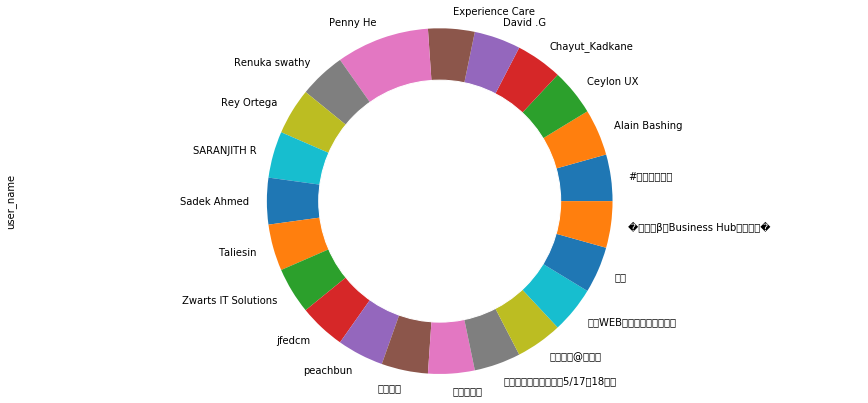

In [3]:
## Set the Chart Dimensions
plt.figure(figsize=(15,7))

## Generate the Pie Plog
twitter_df.user_name.groupby(twitter_df.user_name).count().plot(kind='pie')

## Render Pie Plot as a Donut Plot
my_circle=plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

## Display the Plot
plt.axis('equal')
plt.show()

## References

- Twitter Streaming API Service & Examples
    - https://developer.twitter.com/en/docs/tutorials/consuming-streaming-data
    - https://pythonprogramming.net/twitter-api-streaming-tweets-python-tutorial/
- JSON Explorer
    - https://jsoneditoronline.org/
- Pymssql Library Examples
    - http://pymssql.org/en/stable/pymssql_examples.html
    - https://gist.github.com/hunterowens/08ebbb678255f33bba94
- Pandas & Matplotlib Example
    - https://stackoverflow.com/questions/31499033/how-do-i-plot-a-pie-chart-using-pandas-with-this-data